# CAM(Class Activation Map) 모델 구현 및 평가

<br>

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; U-Net 모델과 U-Net++ 모델의 성능 비교를 수행하였다. 모델 성능 비교를 위해 각 모델의 손실값과 IoU 값을 중심으로 수행하였다. 모델 학습 데이터로는 도로 이미지와 세그멘테이션된 이미지로 구성된 KITTI 데이터셋을 사용하였다. 각 모델의 층은 인코더 4층, 디코더 4층으로 구성되어있으며, 인코더의 필터 수는 64, 128, 256, 512이며, 디코더는 역순이다. 모델 학습은 학습률 1e-4로 설정한 Adam 옵티마이저를 사용하여, 총 100회 수행하였다. U-Net의 최저 손실값은 0.0417이고 이미지 샘플 5개의 IoU값 평균은 0.7578이다. U-Net++의 최저 손실값은 0.0409이고 IoU값 평균은 0.8018이다. U-Net++이 U-Net보다 손실값과 IoU값에 있어 더 좋은 성능을 보임을 확인하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 U-Net 모델과 U-Net++ 모델의 성능 비교를 수행합니다. 모델 성능 비교를 위해 각 모델의 손실값과 IoU 값을 확인합니다. 모델 학습 데이터로는 도로 이미지와 세그멘테이션된 이미지로 구성된 KITTI 데이터셋을 사용합니다. 다음은 본 예제의 목차를 제시한 것입니다.
</span><br><br>

> _1. 데이터셋 생성_
>
> _2. 데이터 전처리 및 데이터 증강_
>
> _3. 모델 생성 및 학습_
>
> _4. 모델 평가_

<br><br>

_**<span style="color:red">※본 예제는 LMS 클라우드가 아닌 로컬에서 진행되어 학습 속도 및 결과 등이 상이할 수 있습니다.</span>**_
***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리 호출
***

In [1]:
import tensorflow as tf
from tensorflow import keras as K
import tensorflow_datasets as tfds

import os
import cv2
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
EPOCH = 5
BATCH_SIZE = 16

<br>

## 2. 데이터셋 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 학습하기 이전에 주어진 데이터를 분석하고자 합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다.
</span><br><br>
    
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용하는 데이터는 KITTI 데이터셋의 세그멘테이션 데이터셋 입니다. 분석 결과 입력 데이터는 0에서 255 사이의 int8 형식의 도로 이미지와 객체가 세그멘테이션된 이미지로 구성되어있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 네트워크 학습 전, 데이터셋을 네트워크에 입력 가능한 크기로 변경하는 데이터 전처리를 수행합니다. 'KITTI' 데이터셋의 경우, 입력 데이터인 이미지의 크기가 상이하기 때문에, 모든 이미지 크기를 224 × 224로 리사이즈 해주었습니다.
</span>

***

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

============================================<DATA INFO>=============================================
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})



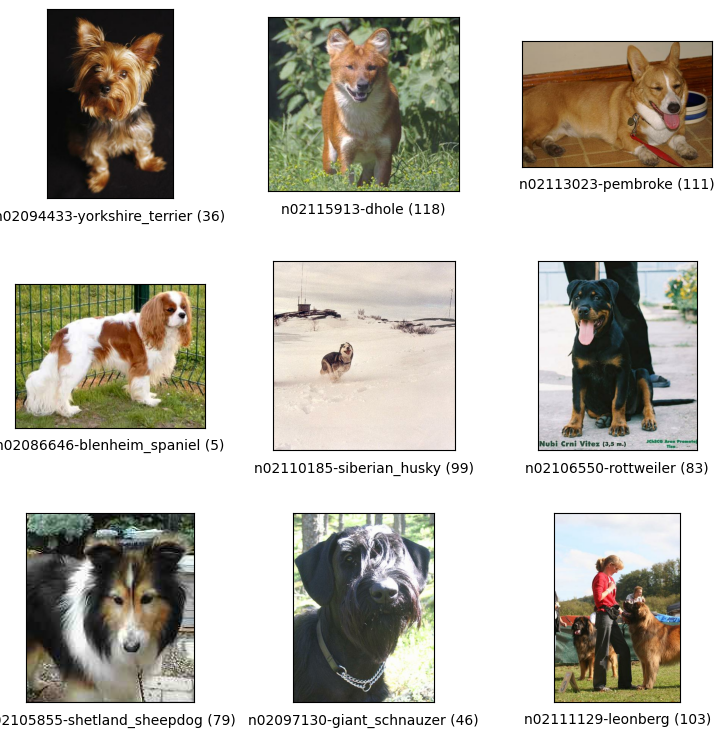

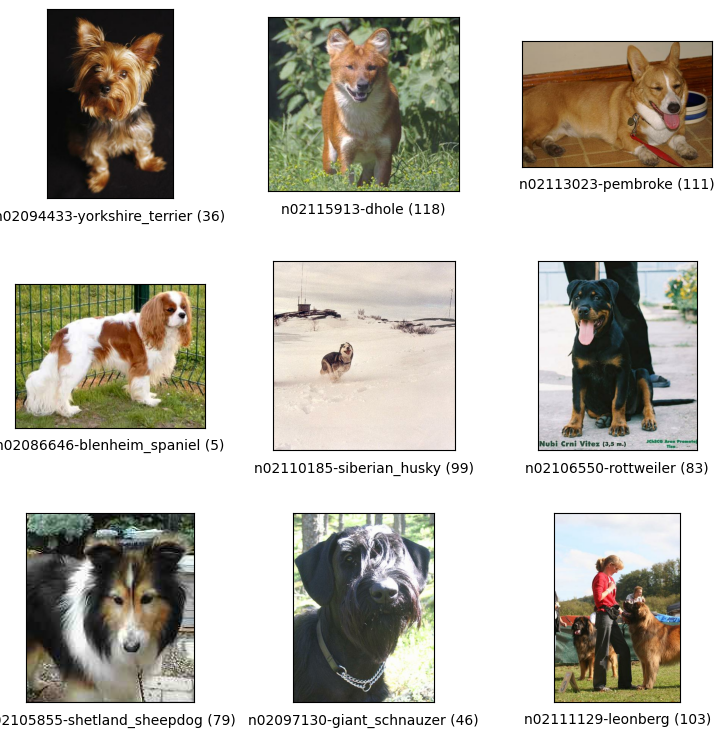

In [4]:
print(f'<DATA INFO>'.center(100, '='))
print(ds_info.features)
print('=' * 100, end='\n\n')
tfds.show_examples(ds_train, ds_info)

In [5]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224]) #resize to 224 by 224
    input['image'] = tf.cast(image, tf.float32) / 255. #Int To Float and normalize
    return input['image'], input['label']


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
#create Dataset
ds_train_norm = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test_norm  = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)


#Print Batch Info
image, label = next(iter(ds_train_norm.take(1)))
print(f'Image Shape:', image.shape)
print(f'Lable Shape:', label.shape)

Image Shape: (16, 224, 224, 3)
Lable Shape: (16,)


<br>

#### 데이터셋 전처리 함수 정의
***
+ `albumentations`를 이용한 데이터셋 전처리 함수 정의


+ 이미지의 크기를 224 × 224로 리사이즈
***

<br>

#### 데이터셋 정의 및 생성
***
+ 예제에 사용되는 학습 데이터를 불러온다.


+ 학습 데이터 셋과 검증 데이터 셋 생성
***

<br>

#### 데이터셋 샘플 시각화
***
+ KITTI 데이터셋 이미지 시각화

***

<br>

## 3. 모델 구현 및 학습
***

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 'U-Net'과 'U-Net++' 성능을 확인하기 위해, 각 모델의 손실 값을 비교합니다. 손실 함수로 'Binary Cross Entropy' 함수를 이용하였습니다. 학습률 1e-4로 설정하여 'Adam' 옵티마이저를 사용하여 총 100 Epoch 학습하였습니다.
</span>

***

In [7]:
num_classes = ds_info.features["label"].num_classes #-> Int(120)
base_model = K.applications.resnet50.ResNet50(
    include_top=False, #Except Last Layer
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)

#Add Last Layer
x = base_model.output
new_last_layer = K.layers.Dense(num_classes, activation='softmax')(x)
cam_model = K.Model(inputs=base_model.input, outputs=new_last_layer)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=K.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [9]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples / BATCH_SIZE),
    epochs=5,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 51s 55ms/step - loss: 2.1931 - accuracy: 0.4521 - val_loss: 3.3158 - val_accuracy: 0.2105
Epoch 2/5
750/750 [==============================] - 40s 54ms/step - loss: 0.7922 - accuracy: 0.7735 - val_loss: 1.2116 - val_accuracy: 0.6517
Epoch 3/5
750/750 [==============================] - 40s 54ms/step - loss: 0.3224 - accuracy: 0.9209 - val_loss: 1.0358 - val_accuracy: 0.7028
Epoch 4/5
750/750 [==============================] - 41s 54ms/step - loss: 0.1317 - accuracy: 0.9762 - val_loss: 0.9588 - val_accuracy: 0.7213
Epoch 5/5
750/750 [==============================] - 41s 55ms/step - loss: 0.0560 - accuracy: 0.9945 - val_loss: 1.0088 - val_accuracy: 0.7108


In [14]:
#Save Model
cam_model_path = f'./model/{EPOCH:04d}.h5'
cam_model.save(cam_model_path)

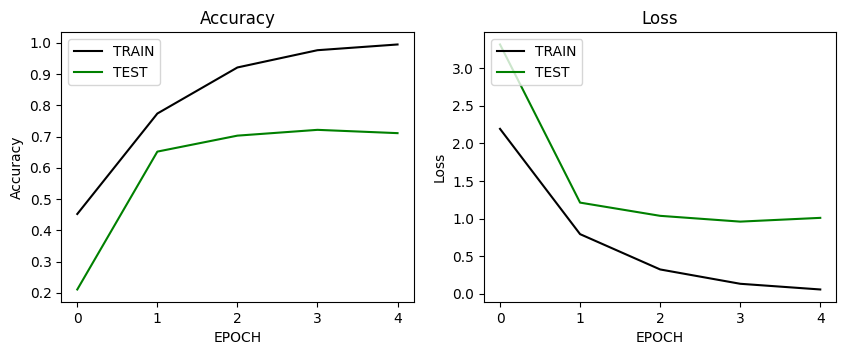

In [34]:
def draw_acc_loss(history):
    def draw_graph(his, sub, ylabel):
        plt.title(ylabel)
        plt.plot(his.history[sub], color='black', label='TRAIN')
        plt.plot(his.history[f'val_{sub}'], color='green', label='TEST')
        plt.xlabel('EPOCH')
        plt.ylabel(ylabel)
        plt.legend(loc='upper left')
    
    plt.figure(figsize=(10, 3.5))
    
    plt.subplot(1, 2, 1)
    draw_graph(history, 'accuracy', 'Accuracy')
    
    plt.subplot(1, 2, 2)
    draw_graph(history, 'loss', 'Loss')
    plt.show()
    
    
draw_acc_loss(history_cam_model)

In [10]:
#Load Model
cam_model = K.models.load_model(f'../datasets/gd_10/model/{EPOCH:04d}.h5')

<br>

#### 공통 함수 정의
***
+ U-Net과 U-Net++ 모델에 공통적으로 사용되는 함수 정의

***

In [5]:
class ConvBlock(layers.Layer):
    def __init__(self, input_size: int):
        conv_info = {'activation': 'relu', 'padding': 'same', 'kernel_initializer': 'he_normal'}
        super(ConvBlock, self).__init__()
        
        self.convs = [layers.Conv2D(input_size, kernel_size=3, **conv_info) for _ in range(2)]
        self.batchNorm = layers.BatchNormalization()
        
    def call(self, x):
        out = x
        for conv in self.convs:
            out = conv(out)
        out = self.batchNorm(out)
        return out
    
    
class ConvTBlock(layers.Layer):
    def __init__(self, input_size: int):
        conv_info = {'strides': (2, 2), 'activation': 'relu', 'kernel_initializer': 'he_normal'}
        super(ConvTBlock, self).__init__()        
        
        self.convT = layers.Conv2DTranspose(filters=input_size, kernel_size=2, **conv_info)

    def call(self, x):
        return self.convT(x)
    

class EncBlock(layers.Layer):
    def __init__(self, input_size: int, is_maxpool: bool=True):
        super(EncBlock, self).__init__()
        self.maxpool = None
        if is_maxpool:
            self.maxpool = layers.MaxPooling2D(pool_size=(2, 2))
        
        self.conv_block = ConvBlock(input_size)
        
    def call(self, x):
        out = x
        if self.maxpool is not None:
            out = self.maxpool(out)
        out = self.conv_block(out)
        return out
    

class DecBlock(layers.Layer):
    def __init__(self, input_size: int):
        super(DecBlock, self).__init__()
        self.upsample = ConvTBlock(input_size)
        self.conv_block = ConvBlock(input_size)
        
        
    def call(self, dec_x, *enc_x):
        dec_x = self.upsample(dec_x)

        out = layers.concatenate([dec_x, *enc_x], axis=3)
        out = self.conv_block(out)
        return out
    
    
class UnetBottleNeck(layers.Layer):
    def __init__(self, input_size: int):
        super(UnetBottleNeck, self).__init__()
        self.conv = ConvBlock(input_size=input_size)
        
    def call(self, x):
        out = x
        enc_out = layers.Dropout(0.5)(out)
        out = layers.MaxPooling2D(pool_size=(2, 2))(enc_out)
        out = self.conv(out)
        dec_out = layers.Dropout(0.5)(out)
        return enc_out, dec_out

<br>

### 3.1. U Net 구현 및 학습

***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; U-Net 모델을 구현하고 학습합니다. 학습률을 1e-4로 설정한 Adam 옵티마이저를 사용하여 총 100회 학습합니다. 검증 데이터셋에 대한 최종 손실값은 0.0533이며, 최저 손실값은 0.0417입니다.
</span>

***


#### U-Net 모델 정의
***
+ 총 파라미터 31,038,725개의 U-Net 모델을 정의

***

In [6]:
class Unet(Model):
    def __init__(self):
        super(Unet, self).__init__()
        
        enc_filters = [64, 128, 256, 512]
        dec_filters = [512, 256, 128, 64]
        
        self.enc_layers = self.__get_ED_layers(filters=enc_filters, block='enc')
        self.bottle_layer = UnetBottleNeck(input_size=1024)
        self.dec_layers = self.__get_ED_layers(filters=dec_filters, block='dec')
        
        self.last_conv1 = layers.Conv2D(
            filters=2, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'
        )
        self.last_conv2 = layers.Conv2D(
            filters=1, kernel_size=1, activation='sigmoid'
        )
        
    def call(self, x):
        out = x
        enc_outs = []
        for idx, layer in enumerate(self.enc_layers):
            out = layer(out)
            if idx < (len(self.enc_layers)-1):
                enc_outs.append(out)

        enc_out, dec_out = self.bottle_layer(out)
        enc_outs.append(enc_out)
        
        for dec_layer, enc_out in zip(self.dec_layers, enc_outs[::-1]):
            dec_out = dec_layer(dec_out, enc_out)

        out = self.last_conv1(dec_out)
        out = self.last_conv2(out)
        return out
    
    def __get_ED_layers(self, filters: list, block: str):
        if block == 'enc':
            layers = [EncBlock(filters[0], False)]
            for size in filters[1:]:
                layers.append(EncBlock(size, True))
            return layers
        
        elif block == 'dec':
            return [DecBlock(size) for size in filters]
        
        print('Default')
        return [DecBlock(size) for size in filters]
    
    def get_summary(self, input_shape=(224, 224, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    

u_model = Unet()
u_model.get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
enc_block (EncBlock)            (None, 224, 224, 64) 38976       input_1[0][0]                    
__________________________________________________________________________________________________
enc_block_1 (EncBlock)          (None, 112, 112, 128 221952      enc_block[0][0]                  
__________________________________________________________________________________________________
enc_block_2 (EncBlock)          (None, 56, 56, 256)  886272      enc_block_1[0][0]                
______________________________________________________________________________________________

<br>

#### U-Net 모델 학습
***
+ 학습률 1e-4의 Adam 옵티마이저를 사용하여 총 100회 학습

***

In [7]:
u_model.compile(optimizer=K.optimizers.Adam(lr=1e-4), loss='binary_crossentropy')

u_his = u_model.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Y:\programFiles\anaconda3\envs\aiffel\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Y:\programFiles\anaconda3\envs\aiffel\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 8s 79ms/step - loss: 0.4295 - val_loss: 0.5894
Epoch 2/100
43/43 [==============================] - 3s 70ms/step - loss: 0.2291 - val_loss: 0.4592
Epoch 3/100
43/43 [==============================] - 3s 69ms/step - loss: 0.1966 - val_loss: 0.4095
Epoch 4/100
43/43 [==============================] - 3s 69ms/step - loss: 0.1781 - val_loss: 0.3513
Epoch 5/100
43/43 [==============================] - 3s 70ms/step - loss: 0.1777 - val_loss: 0.2255
Epoch 6/100
43/43 [==============================] - 3s 69ms/step - loss: 0.1733 - val_loss: 0.1931
Epoch 7/100
43/43 [==============================] - 3s 69ms/step - loss: 0.1618 - val_loss: 0.1852
Epoch 8/100
43/43 [==============================] - 3s 70ms/step - loss: 0.1642 - val_loss: 0.1776
Epoch 9/100
43/43 [==============================] - 3s 70ms/step - loss: 0.1643 - val_loss: 0.1744
Epoch 10/100
43/43 [==============================] - 3s 68ms/step - loss: 0.1628 - val_loss: 0.1748

<br>

### 3.2. U Net++ 구현 및 학습

***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; U-Net++ 모델을 구현하고 학습합니다. 학습률을 1e-4로 설정한 Adam 옵티마이저를 사용하여 총 100회 학습합니다. 검증 데이터셋에 대한 최종 손실값은 0.0464이며, 최저 손실값은 0.0409입니다.
</span>

***


#### U-Net++ 모델 정의
***
+ 총 파라미터 36,165,249개의 U-Net++ 모델을 정의

***

In [7]:
class UppNet(Model):
    def __init__(self):
        super(UppNet, self).__init__()
        enc_filters = [64, 128, 256, 512]
        dec_filters = [512, 256, 128, 64]
        
        self.enc_layers = self.__get_ED_layers(filters=enc_filters, block='enc')
        self.bottle_layer = UnetBottleNeck(input_size=1024)
        self.dec_layers = self.__get_ED_layers(filters=dec_filters, block='dec')
        self.last_conv = layers.Conv2D(1, 1, activation='sigmoid')
        
    def call(self, x):
        out = x
        enc_outs = []
        for idx, layer in enumerate(self.enc_layers):
            out = layer(out)
            if idx < (len(self.enc_layers)-1):
                enc_outs.append(out)

        enc_out, dec_out = self.bottle_layer(out)
        
        
        #Decoder Flow==============================
        enc_outs.extend([enc_out, dec_out])
        
        dec_buff = list()
        enc_li = len(enc_outs) - 1 #enc last idx
        
        for d_i, deep in enumerate(self.dec_layers):
            li = enc_li - d_i #last index
            dec_x, enc_x = enc_outs[li], enc_outs[li-1]
            
            enc_buff = list()
            for w_i, wide in enumerate(deep):
                if w_i == 0:
                    out_d_w = wide(dec_x, enc_x)
                else:
                    out_dP1_w = dec_buff.pop(0)

                    out_d_w = wide(out_dP1_w, enc_x, *enc_buff)

                dec_buff.append(out_d_w)
                enc_buff.append(out_d_w)
        #End=========================================
        
        out = self.last_conv(out_d_w)
        return out

        
    def __get_ED_layers(self, filters: list, block: str):
        layers = []
        if block == 'enc':
            layers = [EncBlock(filters[0], False)]
            for size in filters[1:]:
                layers.append(EncBlock(size, True))
            return layers

        for deep, size in enumerate(filters):
            layers.append(tuple(DecBlock(size) for wide in range(deep+1)))
        return layers
        
        print('Default')
        return layers
    
    def get_summary(self, input_shape=(224, 224, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    

upp_model = UppNet()
upp_model.get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
enc_block_4 (EncBlock)          (None, 224, 224, 64) 38976       input_2[0][0]                    
__________________________________________________________________________________________________
enc_block_5 (EncBlock)          (None, 112, 112, 128 221952      enc_block_4[0][0]                
__________________________________________________________________________________________________
enc_block_6 (EncBlock)          (None, 56, 56, 256)  886272      enc_block_5[0][0]                
____________________________________________________________________________________________

<br>

#### U-Net++ 모델 학습
***
+ 학습률 1e-4의 Adam 옵티마이저를 사용하여 총 100회 학습

***

In [9]:
upp_model.compile(optimizer=K.optimizers.Adam(lr=1e-4), loss='binary_crossentropy')

upp_his = upp_model.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Epoch 1/100
43/43 [==============================] - 13s 178ms/step - loss: 0.6865 - val_loss: 0.6335
Epoch 2/100
43/43 [==============================] - 7s 173ms/step - loss: 0.6100 - val_loss: 0.6157
Epoch 3/100
43/43 [==============================] - 7s 171ms/step - loss: 0.5514 - val_loss: 0.6168
Epoch 4/100
43/43 [==============================] - 7s 172ms/step - loss: 0.4863 - val_loss: 0.4068
Epoch 5/100
43/43 [==============================] - 7s 169ms/step - loss: 0.4235 - val_loss: 0.3195
Epoch 6/100
43/43 [==============================] - 7s 173ms/step - loss: 0.3754 - val_loss: 0.2626
Epoch 7/100
43/43 [==============================] - 7s 170ms/step - loss: 0.3530 - val_loss: 0.3667
Epoch 8/100
43/43 [==============================] - 7s 171ms/step - loss: 0.3242 - val_loss: 0.1724
Epoch 9/100
43/43 [==============================] - 7s 168ms/step - loss: 0.3108 - val_loss: 0.1743
Epoch 10/100
43/43 [==============================] - 7s 169ms/step - loss: 0.3317 - val_l

<br>

## 4. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; U-Net과 U-Net++ 모델을 Adam(learning rate는 1e-4)를 사용하여 총 100회 학습하였습니다. 그 결과, U-Net의 최종 손실값은 0.0533이고 가장 낮은 손실값은 0.0417입니다. U-Net++의 경우 최종 손실값 0.0464이고 최저 손실값은 0.0409입니다. 최종 손실값, 최저 손실값 모두 N-Net++에서 더 낮음을 확인하였습니다. 그림 Loss의 (a)와 (b)는 학습 셋과 검증 셋에 대한 각 모델의 손실 변화를 제시한 것입니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이미지 샘플 5개에 대한 각 모델의 IoU 값을 비교하였습니다. 그 결과, 모든 이미지에 대해 U-Net++ 모델의 IoU 값이 높음을 확인하였습니다. 이미지 샘플 5개에 대한 각 모델의 IoU 평균은, U-Net이 0.7578이고 U-Net++가 0.8018입니다.
</span><br><br>

<br>

<center>Table 1. <b>&lt;검증 셋에 대한 최저 손실값 및 IoU 평균></b></center>

||U-Net|U-Net++|
|:---:|:---:|:---:|
|**Loss**|0.0417|**<span style="color:red">0.0409</span>**|
|**IoU**|0.7578|**<span style="color:red">0.8018</span>**|

***

#### 손실값 변화 시각화 함수 정의
***
+ 학습 셋과 검증 셋에 대한 각 모델의 손실값 변화 시각화 함수 정의

***

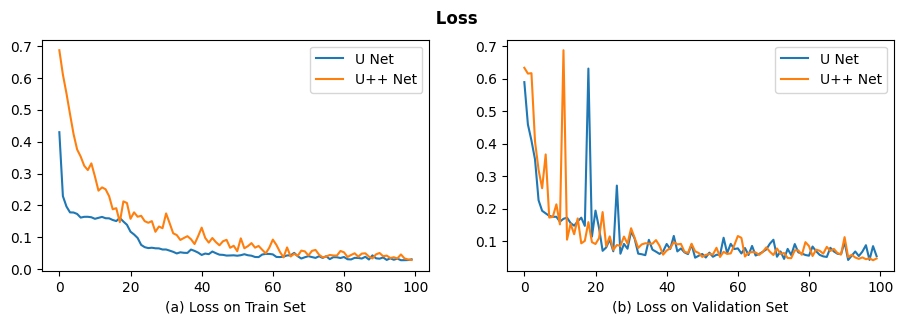

In [10]:
def show_his(u_his, upp_his):
    plt.figure(figsize=(11, 3))
    plt.suptitle(' Loss', fontsize=12, fontweight='bold')
    
    plt.subplot(1, 2, 1)
    plt.plot(u_his.history['loss'], label='U Net')
    plt.plot(upp_his.history['loss'], label='U++ Net')
    plt.legend()
    plt.xlabel('(a) Loss on Train Set', fontsize=10)
    
    plt.subplot(1, 2, 2)
    plt.plot(u_his.history['val_loss'], label='U Net')
    plt.plot(upp_his.history['val_loss'], label='U++ Net')
    plt.legend()
    plt.xlabel('(b) Loss on Validation Set', fontsize=10)
    

show_his(u_his=u_his, upp_his=upp_his)

<br>

#### 세그멘트 시각화 및 IoU 출력 함수 정의
***
+ 각 모델의 특정 수의 이미지에 대한 시각화 및 IoU를 출력하는 함수 정의

***

In [11]:
def calculate_iou_score(target, prediction, is_print: bool=False):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    if is_print:
        print('IoU : %f' %iou_score)
    return iou_score

def get_output(model, preproc, image_path: str, label_path: str, is_imshow: bool=False):
    def get_processed(img_path, preproc):
        img = imread(img_path)
        img = {'image': img}
        return preproc(**img)['image']
    
    processed = get_processed(image_path, preproc)
    output = model(np.expand_dims(processed/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1) * 255
    
    origin_img = imread(image_path)
    prediction = output / 255
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    label_processed = get_processed(label_path, preproc)
    target = (label_processed==7).astype(np.uint8) * 1
    
    if is_imshow:
        plt.imshow(output)
    return output, prediction, target

def evaluate(u_model, upp_model, ex_num: int=1, main_path: str='../datasets/gd_08/dataset/training') -> None:
    def get_result(model, x_path, y_path):
        #img와 iou 반환
        output, pred, target = get_output(
            model=model, preproc=test_preproc, image_path=x_path, label_path=y_path, is_imshow=False
        )
        iou = calculate_iou_score(target, pred)
        return output, iou
    
    def imshow(idx, img, txt) -> None:
        write_title = lambda txt: plt.title(txt, fontdict={'fontsize': 10}, loc='left')
        
        plt.subplot(ex_num, 2, idx)
        plt.axis('off')
        plt.imshow(img)
        write_title(txt)
    
    sample_files = random.choices(
        os.listdir(main_path + '/image_2'),
        k=ex_num
    )
    
    plt.figure(figsize=(11, 2*ex_num))
    plt.suptitle('Evaluation', fontsize=12, fontweight='bold')
    
    for idx, file_name in enumerate(sample_files):
        x_path, y_path = main_path + f'/image_2/{file_name}', main_path + f'/semantic/{file_name}'
        
        u_img, u_iou = get_result(model=u_model, x_path=x_path, y_path=y_path)
        upp_img, upp_iou = get_result(model=upp_model, x_path=x_path, y_path=y_path)
        
        imshow(idx=2*idx+1, img=u_img, txt=f'U Net: {u_iou:.3f}')
        imshow(idx=2*(idx+1), img=upp_img, txt=f'U++ Net: {upp_iou:.3f}')

<br>

#### 세그멘트 시각화 및 IoU 출력
***
+ 5개의 랜덤 이미지 샘플에 대한 모델 별 세그멘트 시각화 및 IoU 출력

***

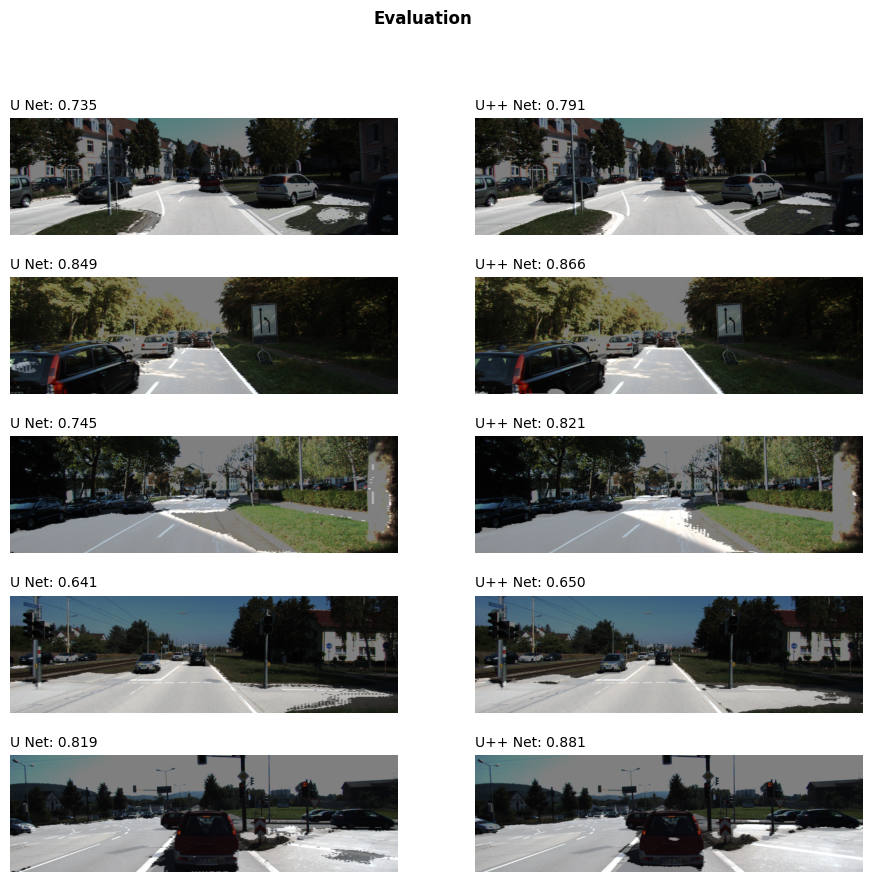

In [14]:
evaluate(u_model=u_model, upp_model=upp_model, ex_num=5)

<br>

## 5. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트에서는 U-Net 모델과 U-Net++ 모델의 성능 비교를 수행하였습니다. 성능 비교를 위해 모델의 손실값과 IoU 값을 확인하였습니다. 모델 학습을 위해 KITTI 데이터셋을 사용하였습니다. 학습률 1e-4로 설정한 Adam 옵티마이저로 총 100회 학습하였습니다. 각 모델의 최저 손실값과 IoU 값을 비교한 결과, 두 수치 모두 U-Net++가 양호함을 확인하였습니다.
</span>

***

<br>

#### 형상관리 기록
***
+ v1_1: 초기 예제
***